<a href="https://colab.research.google.com/github/AmanaFaizal/steamnoodles-feedback-agent-amanaFaizal/blob/main/AgentX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U openai langchain langchain-core langchain-community langchain-groq
!pip install pandas matplotlib seaborn python-dotenv dateparser


In [2]:
import pandas as pd
import re
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from langchain.tools import Tool
from dotenv import load_dotenv
from langchain.agents import initialize_agent, AgentType
from langchain_groq import ChatGroq

In [3]:
load_dotenv()
os.environ["GROQ_API_KEY"] = "put_the_api_key_here"

In [4]:
llm = ChatGroq(model="llama3-70b-8192", temperature=0.7)

In [5]:
CSV_PATH = "/content/drive/MyDrive/SteamNoodles/data/reviews.csv"
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

In [6]:
if not os.path.exists(CSV_PATH):
    df = pd.DataFrame(columns=["date", "review", "sentiment"])
    df.to_csv(CSV_PATH, index=False)

In [7]:
sample_data = [
              {"date": "2025-07-25 10:15:00", "review": "The noodles were absolutely delicious!", "sentiment": "Positive"},
              {"date": "2025-07-29 14:45:00", "review": "The service was quite slow today.", "sentiment": "Negative"},
              {"date": "2025-08-29 18:30:00", "review": "The ambiance was nice but the food was average.", "sentiment": "Neutral"},
              {"date": "2025-08-29 12:10:00", "review": "Absolutely loved the dumplings and the service!", "sentiment": "Positive"},
              {"date": "2025-08-30 19:10:00", "review": "Reasonable prices for the quality offered.", "sentiment": "Neutral"},
              {"date": "2025-08-02 09:50:00", "review": "Highly recommended.", "sentiment": "Positive"},
              {"date": "2025-08-02 10:30:00", "review": "Would not go back.", "sentiment": "Negative"},
              {"date": "2025-08-02 11:45:00", "review": "I was disgusted because I was pretty sure that was human hair.", "sentiment": "Negative"},
              {"date": "2025-08-02 13:37:11", "review": "Ample portions and good prices.", "sentiment": "Positive"},
              {"date": "2025-08-02 14:20:00", "review": "The menu had typical options; nothing unique.", "sentiment": "Neutral"},
              {"date": "2025-08-02 15:25:00", "review": "The cocktails are all handmade and delicious.", "sentiment": "Positive"},
              {"date": "2025-08-02 16:30:00", "review": "Omelets are to die for!", "sentiment": "Positive"},
              {"date": "2025-08-02 20:45:00", "review": "Everything was fresh and delicious!", "sentiment": "Positive"},
              {"date": "2025-08-03 10:37:12", "review": "Will go back next trip out.", "sentiment": "Positive"},
              {"date": "2025-08-03 11:50:00", "review": "Nice, spicy and tender.", "sentiment": "Positive"},
              {"date": "2025-08-03 13:30:00", "review": "The management is rude.", "sentiment": "Negative"},
              {"date": "2025-08-03 20:05:00", "review": "Always a great time at SteamNoodes!", "sentiment": "Positive"},
              {"date": "2025-08-04 08:15:00", "review": "The service was meh.", "sentiment": "Negative"},
              {"date": "2025-08-04 11:05:00", "review": "We'll never go again.", "sentiment": "Negative"},
              {"date": "2025-08-04 19:30:00", "review": "We are so glad we found this place.", "sentiment": "Positive"},
              {"date": "2025-08-04 12:25:00", "review": "The ramen broth was rich and flavorful.", "sentiment": "Positive"},
              {"date": "2025-08-05 20:05:00", "review": "The soup was too salty for my taste.", "sentiment": "Negative"},
              {"date": "2025-08-06 18:15:00", "review": "The music was too loud, hard to have a conversation.", "sentiment": "Negative"},
              {"date": "2025-08-06 09:30:00", "review": "Great portion sizes and very fresh ingredients.", "sentiment": "Positive"},
              {"date": "2025-08-06 14:20:00", "review": "Food was okay, but nothing special.", "sentiment": "Neutral"},
              {"date": "2025-08-06 20:45:00", "review": "The dessert menu was fantastic!", "sentiment": "Positive"},
              {"date": "2025-08-08 11:05:00", "review": "Waited over 30 minutes for my order.", "sentiment": "Negative"},
              {"date": "2025-08-08 15:37:12", "review": "I could care less... The interior is just beautiful.", "sentiment": "Positive"},
              {"date": "2025-08-08 19:50:00", "review": "Staff was polite and welcoming.", "sentiment": "Positive"},
              {"date": "2025-08-09 13:30:00", "review": "The table was not clean when we arrived.", "sentiment": "Negative"},
              {"date": "2025-08-10 17:45:00", "review": "Overcooked vegetables in my dish.", "sentiment": "Negative"},
              {"date": "2025-08-15 17:24:47", "review": "The service was very slow yesterday.", "sentiment": "Negative"},
              {"date": "2025-08-15 17:24:48", "review": "The foods are mouth watering.", "sentiment": "Positive"}
        ]

pd.DataFrame(sample_data).to_csv(CSV_PATH, index=False)
print("✅ Extended sample data added to CSV for testing.")

✅ Extended sample data added to CSV for testing.


In [8]:
def detect_sentiment(feedback: str) -> str:
    """Classify sentiment as Positive, Negative, or Neutral."""
    prompt = f"Classify the sentiment of the following feedback as Positive, Negative, or Neutral ONLY. No extra words:\n\n{feedback}"
    response = llm.invoke(prompt)
    sentiment = response.content.strip()

    # Ensure only one of the three valid values
    if "positive" in sentiment.lower():
        return "Positive"
    elif "negative" in sentiment.lower():
        return "Negative"
    elif "neutral" in sentiment.lower():
        return "Neutral"
    else:
        return "Neutral"  # Default if unclear


In [9]:

def append_to_csv(review: str, sentiment: str, date: str = None):
    """Append review data to CSV."""
    if date is None:
        date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    new_row = pd.DataFrame([{
        "date": date,
        "review": review,
        "sentiment": sentiment
    }])
    if os.path.exists(CSV_PATH):
        new_row.to_csv(CSV_PATH, mode='a', header=False, index=False)
    else:
        new_row.to_csv(CSV_PATH, mode='w', header=True, index=False)


In [10]:
def generate_reply(feedback: str) -> str:
    """Generate polite reply and store in CSV."""
    sentiment = detect_sentiment(feedback)
    prompt = (
        f"A customer left this {sentiment} feedback:\n'{feedback}'\n"
        f"Write a short, polite, and professional response."
    )
    response = llm.invoke(prompt)
    reply = response.content.strip()
    append_to_csv(feedback,sentiment)
    return reply

In [11]:
import dateparser
from datetime import datetime, timedelta

def parse_date_range(date_range_str: str):
    """Parse a flexible date range string into (start_date, end_date) datetime objects.

    Supports formats:
    - "YYYY-MM-DD,YYYY-MM-DD"
    - "YYYY-MM-DD to YYYY-MM-DD"
    - "last 7 days" or "last seven days"
    - "August 1 to August 7" (assumes current year if year missing)
    - Single dates like "2025-08-01", "yesterday", "3 days ago"
    """
    date_range_str = date_range_str.strip().lower()

    settings = {
        'PREFER_DATES_FROM': 'past',   # Prefer past dates for ambiguous ones
        'RELATIVE_BASE': datetime.now()  # Base for relative dates like "3 days ago"
    }

    # Handle "today"
    if date_range_str == "today":
        today = datetime.now()
        start = today.replace(hour=0, minute=0, second=0, microsecond=0)
        end = today.replace(hour=23, minute=59, second=59, microsecond=999999)
        return start, end

    # Handle "yesterday"
    if date_range_str == "yesterday":
        yesterday = datetime.now() - timedelta(days=1)
        start = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        end = yesterday.replace(hour=23, minute=59, second=59, microsecond=999999)
        return start, end

    # 1. Handle comma-separated ranges: "YYYY-MM-DD,YYYY-MM-DD"
    if "," in date_range_str:
        parts = date_range_str.split(",")
        if len(parts) == 2:
            start = dateparser.parse(parts[0].strip(), settings=settings)
            end = dateparser.parse(parts[1].strip(), settings=settings)
            if start and end:
                return start, end

    # 2. Handle "to" separated ranges: "YYYY-MM-DD to YYYY-MM-DD" or "August 1 to August 7"
    if " to " in date_range_str:
        parts = date_range_str.split(" to ")
        if len(parts) == 2:
            start = dateparser.parse(parts[0].strip(), settings=settings)
            end = dateparser.parse(parts[1].strip(), settings=settings)
            if start and end:
                # If year missing, dateparser sets year to 1900, fix to current year
                now = datetime.now()
                if start.year < 2000:
                    start = start.replace(year=now.year)
                if end.year < 2000:
                    end = end.replace(year=now.year)
                return start, end

    # 3. Handle "last N days" or "last seven days"
    if date_range_str.startswith("last"):
        import re
        match = re.search(r"last (\d+|[a-z]+) days", date_range_str)
        if match:
            num_days_str = match.group(1)
            # Convert word numbers to int if necessary
            word_to_num = {
                "one": 1, "two": 2, "three": 3, "four": 4,
                "five": 5, "six": 6, "seven": 7, "eight": 8,
                "nine": 9, "ten": 10
            }
            if num_days_str.isdigit():
                num_days = int(num_days_str)
            else:
                num_days = word_to_num.get(num_days_str, None)
            if num_days is not None:
                end = datetime.now()
                start = end - timedelta(days=num_days)
                return start, end

    # 4. Try parsing as a single date or relative date
    single_date = dateparser.parse(date_range_str, settings=settings)
    if single_date:
        return single_date, single_date

    # If all fails
    return None, None


In [12]:
class SentimentPlotter:
    def __init__(self):
        self.plot_counter = 1

    def safe_parse_date_range(self, date_range_str: str):
        try:
            start_date, end_date = parse_date_range(date_range_str)
            if not start_date or not end_date:
                raise ValueError("Could not parse dates")
            return start_date, end_date
        except Exception:
            return None, None

    def __call__(self, date_range_str: str):
        start, end = self.safe_parse_date_range(date_range_str)
        if not start or not end:
            return (" Sorry, I couldn’t understand that date range.\n"
                    "Try formats like:\n"
                    "- 'last 7 days'\n"
                    "- '2025-08-01 to 2025-08-10'\n"
                    "- '2025-08-01 , 2025-08-10'\n"
                    "- 'August 1 to August 7'")
        return self.plot_sentiment(start, end)

    def plot_sentiment(self, start_date: datetime, end_date: datetime):
        if not os.path.exists(CSV_PATH):
            return "No data found to plot. Please add some reviews first."
        df = pd.read_csv(CSV_PATH, parse_dates=["date"])
        df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
        if df.empty:
            return "No reviews found for the selected date range."

        full_dates = pd.date_range(start=start_date, end=end_date, freq="D")
        # Prepare counts with all dates
        counts = df.groupby([df["date"].dt.date, "sentiment"]).size().unstack(fill_value=0)
        # Add missing dates with zeros
        counts = counts.reindex(full_dates.date, fill_value=0)
        counts.plot(kind="bar", figsize=(8, 5))
        plt.title("Sentiment Trends")
        plt.xlabel("Date")
        plt.ylabel("Number of Reviews")
        plt.tight_layout()
        filename = f"sentimentplot{self.plot_counter}.png"
        self.plot_counter += 1
        return "sentimentplot{self.plot_counter}.png"

plotter = SentimentPlotter()

In [13]:
sentiment_tool = Tool(
    name="SentimentDetector",
    func=detect_sentiment,
    description="Detect sentiment from customer feedback text."
)

In [14]:
reply_tool = Tool(
    name="ReplyGenerator",
    func=generate_reply,
    description="Generate polite, professional reply to customer feedback."
)

In [15]:
plot_tool = Tool(
    name="SentimentPlotter",
    func=plotter,
    description="Generate a sentiment trend plot for a given date range."
)

In [16]:
agent = initialize_agent(
    tools=[sentiment_tool, reply_tool, plot_tool],
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

/tmp/ipython-input-2169452410.py:1: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [17]:
# Example 1: Detect sentiment
print(agent.run("Detect sentiment for: The noodles were delicious and the staff was friendly."))


/tmp/ipython-input-1133796307.py:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(agent.run("Detect sentiment for: The noodles were delicious and the staff was friendly."))




> Entering new AgentExecutor chain...
Thought: I need to detect the sentiment of the given customer feedback.

Action: SentimentDetector
Action Input: The noodles were delicious and the staff was friendly.
Observation: Positive
Thought:I now know the sentiment of the customer feedback.

Final Answer: The sentiment of the customer feedback is Positive.

> Finished chain.
The sentiment of the customer feedback is Positive.


In [18]:
# Example 2: Generate reply
print(agent.run("Generate a reply for feedback: The service was very slow yesterday."))




> Entering new AgentExecutor chain...
Thought: I need to generate a polite and professional reply to the customer's feedback.

Action: ReplyGenerator
Action Input: The service was very slow yesterday.
Observation: Here is a short, polite, and professional response:

"Dear valued customer,

Thank you for taking the time to share your feedback with us. We apologize for the slow service you experienced yesterday. We understand the importance of prompt service and are truly sorry that we fell short of our standards. We will take immediate action to address this issue and ensure that our service meets your expectations in the future.

Thank you for your patience and understanding. If you have any further concerns, please don't hesitate to reach out to us.

Best regards, [Your Name]"
Thought:I now know the final answer.

Final Answer: Here is a short, polite, and professional response:

"Dear valued customer,

Thank you for taking the time to share your feedback with us. We apologize for t

In [19]:
# Example 2: Generate reply
print(agent.run("Generate a reply for feedback: The foods are mouth watering."))



> Entering new AgentExecutor chain...
Thought: I need to generate a polite and professional reply to the customer feedback.

Action: ReplyGenerator
Action Input: "The foods are mouth watering."
Observation: Here is a possible response:

"Thank you so much for taking the time to share your kind words about our food! We're thrilled to hear that you enjoyed your dining experience with us. We strive to serve delicious and satisfying meals, and it's great to know that we've been able to do just that for you. We appreciate your feedback and look forward to serving you again soon!"
Thought:I now know the final answer
Final Answer: "Thank you so much for taking the time to share your kind words about our food! We're thrilled to hear that you enjoyed your dining experience with us. We strive to serve delicious and satisfying meals, and it's great to know that we've been able to do just that for you. We appreciate your feedback and look forward to serving you again soon!"

> Finished chain.
"T

sentimentplot{self.plot_counter}.png


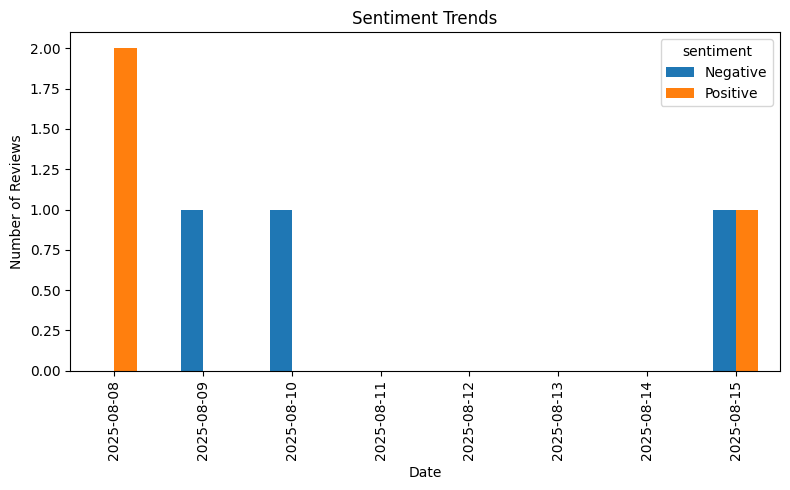

In [20]:
# Example 3: Generate sentiment plot
print(plotter("last 7 days"))

sentimentplot{self.plot_counter}.png


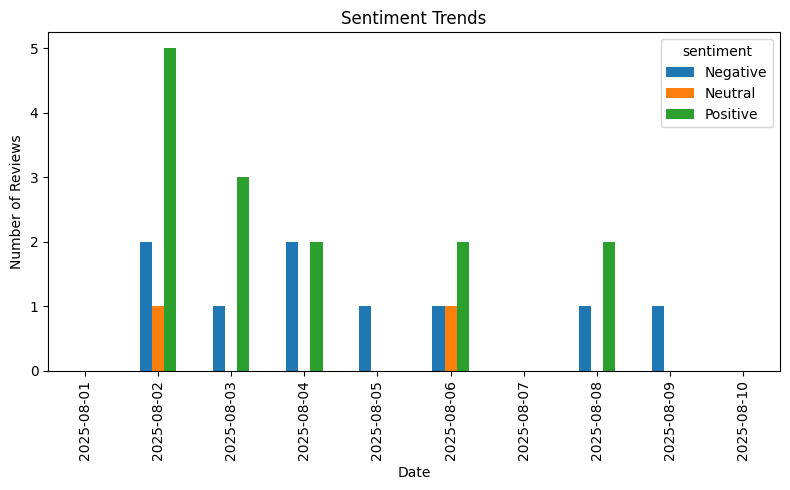

In [21]:
print(plotter("2025-08-01 , 2025-08-10"))

In [22]:
print(plotter("Yesterday"))

No reviews found for the selected date range.


sentimentplot{self.plot_counter}.png


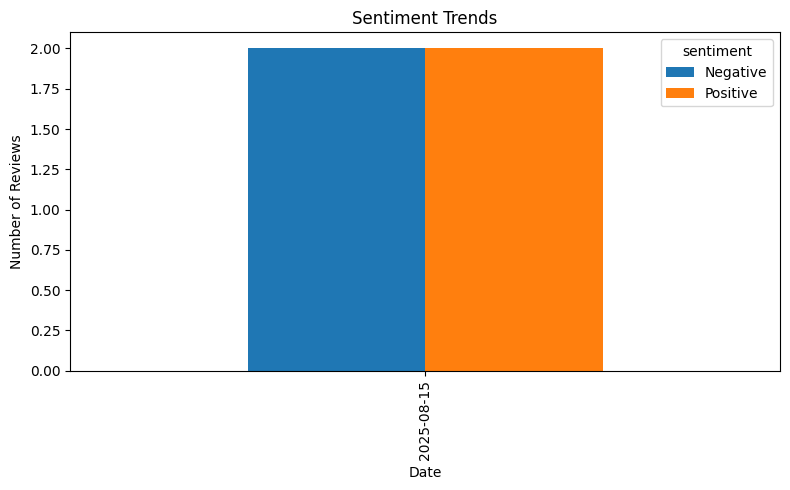

In [23]:
print(plotter("today"))